In [1]:
import requests, json
from random import randrange
import math
import pandas as pd 
import numpy as np
from gensim.models import KeyedVectors
from spellchecker import SpellChecker
spell = SpellChecker(language='fr')

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.manifold import TSNE
from sklearn import cluster

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import pyplot
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

C:\Users\mehdi\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\mehdi\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


### <font color=red>  **I. Chargement et nettoyage des données**

In [2]:
data=pd.read_excel("verbatims_SRC_230118_ENSAE.xlsx")
data.head()

id REPRISE_ACTIVITE REPRISE_INTERLOCUTEUR  recommandation_SGK  \
0  43575       Prévoyance              Adhérent                   7   
1  60754          Epargne              Adhérent                   7   
2  11055       Prévoyance              Adhérent                   5   
3  57592       Prévoyance              Adhérent                   0   
4  89335       Prévoyance              Adhérent                   4   

                              raisons_recommandation  
0  Satisfaite du service mais pas évident d'avoi ...  
1                         Bonne relation téléphoniqe  
2  Lors de mon appel téléphonique le conseillé do...  
3  en attente d'une réponse depuis mi septembre, ...  
4  Beaucoup trop de soucis administratifs, pour a...

In [27]:
stop_words_fr = open("stopword_fr.txt", "r")
lines = stop_words_fr.readlines()
lines=[ele.strip('\n') for ele in lines]
stop_words_list=lines
#ci-dessous, permettre de nettoyer les verbatims 
lettres=list("-*.azertyuiopqsdfghjklmwxcvbnAZERTYUIOPQSDFGHJKLMWXCVBNéàèùôïëäêîôÉ!?ç'")

def mot_propre(word):
    neg=False
    if "n'" in word:
        neg=True
        word=word.replace("n'","n ")
        li = word.split(' ')[0]
        word=word.split(' ')[1]
    for i in range(len(word)):
        if word[i] not in lettres:
            word=word.replace(word[i],'*')
        if word[i]=='-':
            word=word.replace(word[i],' ')
        if word[i]=="'":
            if i==0:
                word=word.replace(word[i],'*')
            else:
                word=word[0:i-1]+word[i+1:]+"*"+"*"
        if word[i]=='!':
            word=word.replace(word[i],' ! ')
            #i=i-1
        if word[i]=='.':
            word=word.replace(word[i],' . ')
    word=word.replace('*','')
    if neg:
        return [li]+[word]
    else:
        return word



On charges les vecteurs de mots pré-entrainés

In [22]:
mot_model = KeyedVectors.load_word2vec_format('wiki.fr.vec')

**III. Transformation des mots en vecteurs**

Ignorons d'abord les mots mal orthographiés pour voir ce que cela donne.

In [26]:
def to_seq(verbatims):
    #chaque verbatim est transformé en sequence de vecteur
    sentence=[]
    sequenc=[]
    maxlen=0
    for verba in verbatims:
        sen=[]
        aux=verba.split(' ')
        res=[]
        for i in range(len(aux)):
            if '!' in aux[i] or '.' in aux[i] or '?' in aux[i]:
                if type(mot_propre(aux[i]))==list:
                    k=mot_propre(aux[i])[0].split(' ')
                    k=[e for e in k if e!='']
                    res+=k
                    k=mot_propre(aux[i])[1].split(' ')
                    k=[e for e in k if e!='']
                    res+=k
                else:
                    k=mot_propre(aux[i]).split(' ')
                    k=[e for e in k if e!='']
                    res+=k
            else:
                if type(mot_propre(aux[i]))==list:
                    res+=[mot_propre(aux[i])[0]]+[mot_propre(aux[i])[1]]
                else:
                    res+=[mot_propre(aux[i])]
        seq=[]
        for w in res:
            if w not in stop_words_list:
                try:
                    seq.append(mot_model[w.lower()])
                    sen.append(w)
                except:
                    'error'
        sequenc.append(seq)
        sentence.append(sen)
        if len(seq)>maxlen:
            maxlen=len(seq)
    return sequenc,maxlen,sentence


In [78]:
Base_train, Base_test = train_test_split(data[["recommandation_SGK","raisons_recommandation"]],test_size=0.2)

In [87]:
Base_train.to_excel("Train.xlsx")
Base_test.to_excel("Test.xlsx")

In [79]:
Base_train.head()

recommandation_SGK                             raisons_recommandation
1541                   8                                          Amabilité
4714                   6  Cette fois ci du mieux , la personne ses donne...
5693                   0  Le capital garanti  n'est pas attrayant au cas...
5753                   8  Les demandes d'informations complémentaires so...
4737                   0  Beaucoup trop de temps entre l'envoi des pièce...

In [80]:
X_train,y_train,X_test,y_test=list(Base_train["raisons_recommandation"].apply(str)),list(Base_train["recommandation_SGK"]),list(Base_test["raisons_recommandation"].apply(str)),list(Base_test["recommandation_SGK"])

In [81]:
X_train,maxlentrain,converted_train=to_seq(X_train)
X_test,maxlentest,converted_test=to_seq(X_test)
maxlen=max(maxlentest,maxlentrain)

In [82]:
def pad(liste,maxlen):
    """Takes a list of sequences as input and returns the same list where each sequences is padded to reach 
    a length of maxlen"""
    for ele in liste:
        while len(ele) < maxlen :
            ele.append(np.zeros((300,)))
    return liste

In [83]:
X_train=pad(X_train,maxlen)
X_test=pad(X_test,maxlen)

In [84]:
X_train=np.array(X_train)

In [85]:
X_test=np.array(X_test)

**2. Clustering et T-SNE**

Là ça serait cool de faire du clustering et utiliser T-SNE, comme a dit Kent ou meme du kmeans modifié comme ça on peut voir ressortir des groupes :) et peut etre nos categories

Il nous faut d'abord agréger chaque verbatims (qui est à ce stade une séquence de vecteurs) en un seul vecteur. Pour cela on peut penser à plusieurs méthode d'agrégation, commençons par essayer une méthode simple qui consiste à prendre faire la moyenne des vecteurs de la séquence. 

Note: En faisant cela, le vecteur moyen obtenu n'a plus le même sens que les vecteurs précédents qui représentait des mots, le vecteur moyen ne représente a priori rien.

In [61]:
X_train.shape

(4667, 233, 300)

In [154]:
""" Retrieve the unique words to compute tf idf 
This is done without any stemming/tokenization for to preserve the differences between words of the same root 
but having different word vectors
"""
vocab_train=[]
for sent in converted_train:
    for word in sent:
        vocab_train.append(word)
#58505 words different
unique_word=list(set(vocab_train))

In [162]:
""" Theses functions are used to compute the TFIDF values for each word in each sentence """

def TFDict(review):
    TFDict = {}
    for word in review:
        if word in TFDict:
            TFDict[word] += 1
        else:
            TFDict[word] = 1          
    for word in TFDict:
        TFDict[word] = TFDict[word] / len(review)
    return TFDict

tfdict={}
for i in range(len(converted_train)):
    tfdict[i]=TFDict(converted_train[i])


def CountDict():
    countDict = {}
    for review in converted_train:
        for word in review:
            if word in countDict:
                countDict[word] += 1
            else:
                countDict[word] = 1
    return countDict


countdict = CountDict()
import math
def IDFDict():
    idfdict = {}
    for word in countdict:
        idfdict[word] = math.log(len(converted_train) / countdict[word])
    return idfdict
  

idfdict = IDFDict()

def computeReviewTFIDFDict(review):
    TFIDFDict = {}
    for word in converted_train[review]:
        TFIDFDict[word] = tfdict[review][word] * idfdict[word]
    return TFIDFDict


word2tfidf  = [computeReviewTFIDFDict(review) for review in range(len(converted_train))]

In [156]:
def agregate(array):
    """ This function takes an array of shape (n_sample, time_steps, n_features) and returns an array of shape 
    (n_sample,n_features). The goal is to represent each sentence by one vector in stead of a sequence of vectors.
    Each sentence is reduced to one vector by doing a weighted sum of all word-vectors where the weights are the 
    tf-idf values."""
    res=np.zeros((array.shape[0],300))
    for i in range(array.shape[0]):
        if word2tfidf[i] == {}:
            'ok'
        else:
            norm=sum(list(word2tfidf[i].values()))
            res[i]+=array[i,0,:]*list(word2tfidf[i].values())[0]/norm
            for k in range(1,len(word2tfidf[i])):
                res[i]+=array[i,k,:]*list(word2tfidf[i].values())[k]/norm
    return res


In [157]:
%time ag_train=agregate(X_train)

Wall time: 703 ms


In [158]:
ag_train.shape

(4667, 300)

In [160]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 300-D -> 2-D
%time tsne_w2v = tsne_model.fit_transform(ag_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4667 samples in 0.104s...
[t-SNE] Computed neighbors for 4667 samples in 17.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4667
[t-SNE] Computed conditional probabilities for sample 2000 / 4667
[t-SNE] Computed conditional probabilities for sample 3000 / 4667
[t-SNE] Computed conditional probabilities for sample 4000 / 4667
[t-SNE] Computed conditional probabilities for sample 4667 / 4667
[t-SNE] Mean sigma: 0.335003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.953545
[t-SNE] KL divergence after 1000 iterations: 2.630889
Wall time: 59.6 s


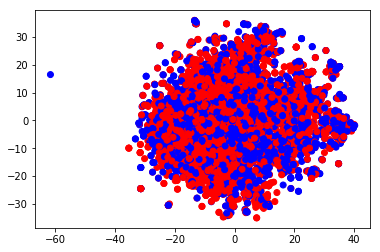

In [161]:
categories=list(data.iloc[Base_train.index].REPRISE_ACTIVITE.map({"Prévoyance":0,"Epargne":1}))


data_plot=np.zeros((4667,3))
data_plot[:,0]=tsne_w2v[:,0]
data_plot[:,1]=tsne_w2v[:,1]
data_plot[:,2]=np.array(categories)

col=["red" for k in range(len(data_plot))]
for i in range(len(col)):
    if data_plot[i,2]==1:
        col[i]='blue'

plt.scatter(tsne_w2v[:,0],tsne_w2v[:,1],c=col)

Pour cette première tentative de clustering, on ne semble pas distinguer de séparation entre les deux types (en dimensions 2).

<h4> IV. Construction d'un réseau de neurones récurrent type LSTM **</h4>

In [193]:
X_train[:,:30,:].shape,X_test.shape

((4667, 30, 300), (1167, 233, 300))

On vérifie que les dimensions sont les bonnes :) - le 30 est arbitraire, à définir mieux en voyant les stats descriptives

In [190]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train.shape,y_test.shape

((4667,), (1167,))

In [86]:
def construct_model(units=128,dims=[30,300]):
    """ LSTM model with two stacked layers, dropout is set to 0.5 and recurrent_dropout to 0.2 for 
    regularization """
    model = Sequential()
    model.add(LSTM(units, input_shape=(dims[0], dims[1]),dropout=0.5,recurrent_dropout=0.2,return_sequences=True))
    model.add(LSTM(32,dropout=0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])
    return model

In [88]:
""" w is set to 50, it will be the number of words we consider in each sentence, this is to make training faster and less
demanding for our computer. 
200 epochs is motivated by the same argument"""
w=50
model=construct_model(units=64,dims=[w,300])
filepath="model4 - 2layer.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history=model.fit(X_train[:,:w,:], y_train,
          epochs=200,
          batch_size=32,
          validation_split=0.2,
          callbacks=callbacks_list)

Train on 3733 samples, validate on 934 samples
Epoch 1/200
3733/3733 [==============================] - 42s 11ms/step - loss: 17.7663 - mean_absolute_error: 3.4951 - val_loss: 10.5239 - val_mean_absolute_error: 2.7477

Epoch 00001: val_loss improved from inf to 10.52394, saving model to model4 - 2layer.hdf5
Epoch 2/200
3733/3733 [==============================] - 9s 2ms/step - loss: 10.4650 - mean_absolute_error: 2.7233 - val_loss: 7.9758 - val_mean_absolute_error: 2.3217

Epoch 00002: val_loss improved from 10.52394 to 7.97579, saving model to model4 - 2layer.hdf5
Epoch 3/200
3733/3733 [==============================] - 9s 2ms/step - loss: 8.2947 - mean_absolute_error: 2.3227 - val_loss: 6.3107 - val_mean_absolute_error: 1.9970

Epoch 00003: val_loss improved from 7.97579 to 6.31073, saving model to model4 - 2layer.hdf5
Epoch 4/200
3733/3733 [==============================] - 8s 2ms/step - loss: 6.9872 - mean_absolute_error: 2.0690 - val_loss: 6.0548 - val_mean_absolute_error: 1.9115



Epoch 00034: val_loss did not improve from 4.48091
Epoch 35/200
3733/3733 [==============================] - 9s 2ms/step - loss: 3.6474 - mean_absolute_error: 1.4457 - val_loss: 4.5204 - val_mean_absolute_error: 1.5830

Epoch 00035: val_loss did not improve from 4.48091
Epoch 36/200
3733/3733 [==============================] - 11s 3ms/step - loss: 3.5120 - mean_absolute_error: 1.4193 - val_loss: 4.4364 - val_mean_absolute_error: 1.5766

Epoch 00036: val_loss improved from 4.48091 to 4.43636, saving model to model4 - 2layer.hdf5
Epoch 37/200
3733/3733 [==============================] - 9s 2ms/step - loss: 3.4147 - mean_absolute_error: 1.3959 - val_loss: 4.4587 - val_mean_absolute_error: 1.5603

Epoch 00037: val_loss did not improve from 4.43636
Epoch 38/200
3733/3733 [==============================] - 9s 2ms/step - loss: 3.6368 - mean_absolute_error: 1.4439 - val_loss: 4.4150 - val_mean_absolute_error: 1.5621

Epoch 00038: val_loss improved from 4.43636 to 4.41502, saving model to mode


Epoch 00071: val_loss did not improve from 4.41502
Epoch 72/200
3733/3733 [==============================] - 9s 2ms/step - loss: 2.2898 - mean_absolute_error: 1.1533 - val_loss: 4.9035 - val_mean_absolute_error: 1.5863

Epoch 00072: val_loss did not improve from 4.41502
Epoch 73/200
3733/3733 [==============================] - 9s 2ms/step - loss: 2.2318 - mean_absolute_error: 1.1446 - val_loss: 4.8469 - val_mean_absolute_error: 1.5774

Epoch 00073: val_loss did not improve from 4.41502
Epoch 74/200
3733/3733 [==============================] - 9s 2ms/step - loss: 2.2301 - mean_absolute_error: 1.1463 - val_loss: 4.7141 - val_mean_absolute_error: 1.5632

Epoch 00074: val_loss did not improve from 4.41502
Epoch 75/200
3733/3733 [==============================] - 9s 2ms/step - loss: 2.1867 - mean_absolute_error: 1.1401 - val_loss: 4.7921 - val_mean_absolute_error: 1.5676

Epoch 00075: val_loss did not improve from 4.41502
Epoch 76/200
3733/3733 [==============================] - 9s 2ms/ste

3733/3733 [==============================] - 9s 2ms/step - loss: 1.6721 - mean_absolute_error: 1.0026 - val_loss: 4.7054 - val_mean_absolute_error: 1.5511

Epoch 00109: val_loss did not improve from 4.41502
Epoch 110/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.7462 - mean_absolute_error: 1.0116 - val_loss: 4.8225 - val_mean_absolute_error: 1.5592

Epoch 00110: val_loss did not improve from 4.41502
Epoch 111/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.7003 - mean_absolute_error: 1.0028 - val_loss: 4.6823 - val_mean_absolute_error: 1.5458

Epoch 00111: val_loss did not improve from 4.41502
Epoch 112/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.6933 - mean_absolute_error: 1.0071 - val_loss: 4.9585 - val_mean_absolute_error: 1.5860

Epoch 00112: val_loss did not improve from 4.41502
Epoch 113/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.7092 - mean_absolute_error: 1.0066 - val_loss: 4.

3733/3733 [==============================] - 9s 2ms/step - loss: 1.2651 - mean_absolute_error: 0.8661 - val_loss: 4.6558 - val_mean_absolute_error: 1.5297

Epoch 00183: val_loss did not improve from 4.41502
Epoch 184/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.2271 - mean_absolute_error: 0.8599 - val_loss: 4.9816 - val_mean_absolute_error: 1.5687

Epoch 00184: val_loss did not improve from 4.41502
Epoch 185/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.2577 - mean_absolute_error: 0.8696 - val_loss: 5.0470 - val_mean_absolute_error: 1.5739

Epoch 00185: val_loss did not improve from 4.41502
Epoch 186/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.2447 - mean_absolute_error: 0.8613 - val_loss: 4.8800 - val_mean_absolute_error: 1.5607

Epoch 00186: val_loss did not improve from 4.41502
Epoch 187/200
3733/3733 [==============================] - 9s 2ms/step - loss: 1.2044 - mean_absolute_error: 0.8530 - val_loss: 4.

In [163]:
score, acc = model.evaluate(X_test[:,:w,:], y_test)
print(score,acc)

1167/1167 [==============================] - 1s 1ms/step
5.1039260718795925 1.616125516638147


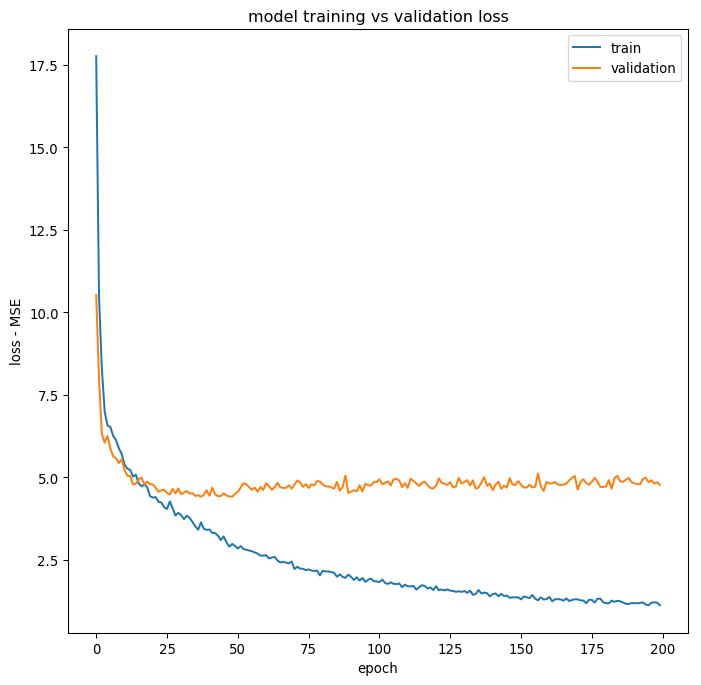

In [165]:
my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
pyplot.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
pyplot.title('model training vs validation loss')
pyplot.ylabel('loss - MSE')
pyplot.xlabel('epoch')
pyplot.legend(['train','validation'], loc='upper right')
pyplot.show()

In [167]:
""" Reloading the weights of the best model obtained during training """

w=50
best = Sequential()
best.add(LSTM(64, input_shape=(w, 300),dropout=0.5,recurrent_dropout=0.1,return_sequences=True))
best.add(LSTM(32,dropout=0.5))
best.add(Dense(1, activation='relu'))
best.load_weights("model4 - 2layer.hdf5")
best.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])


y_pred=best.predict(X_test[:,:w,:])
y_pred_train=best.predict(X_train[:,:w,:])

In [168]:
res=pd.DataFrame()
res["Actual"]=y_test
res["Predicted"]=y_pred
res.head()

Actual  Predicted
0       6   5.870419
1       6   5.006145
2       0   1.809343
3       0   6.935840
4       9   9.072565

In [169]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 1.6014295525548798
Mean Squared Error: 4.733942487542948
Root Mean Squared Error: 2.175762507155353


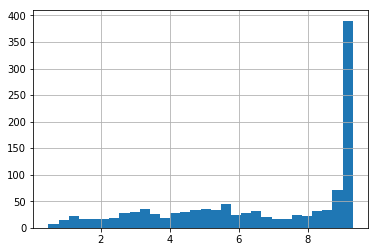

In [94]:
res["Predicted"].hist(bins=30)
plt.show()

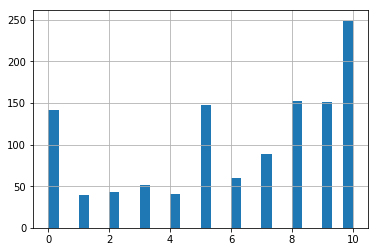

In [95]:
res["Actual"].hist(bins=30)
plt.show()

Pour comparer avec les résultats de l'an dernier, on coupe les notes en 3 catégories:

    -pas satisfait : notes <=3.34
    -moyennement satisfait: 3.34<notes<=6.67
    -satisfait : note>6.67

In [170]:
def to_categorie(x):
    if x<=5:
        return "pas satisfait"
    elif 3.34<x<=6.67:
        return " satisfait"
    else:
        return "satisfait"

res["cat_reelle"]=res["Actual"].apply(to_categorie)
res["cat_predite"]=res["Predicted"].apply(to_categorie)
res.head()

Actual  Predicted     cat_reelle    cat_predite
0       6   5.870419      satisfait      satisfait
1       6   5.006145      satisfait      satisfait
2       0   1.809343  pas satisfait  pas satisfait
3       0   6.935840  pas satisfait      satisfait
4       9   9.072565      satisfait      satisfait

In [171]:
acc=sum(res["cat_reelle"]==res["cat_predite"])/len(res)
acc

0.7317909168808912

<h3> Accuracy de 73.2% contre 68% l'an dernier </h3>

In [98]:
rest=pd.DataFrame()
rest["Actual_train"]=y_train
rest["Predicted_train"]=y_pred_train
rest.head()

Actual_train  Predicted_train
0             8         9.143380
1             6         6.120022
2             0         3.160829
3             8         6.006621
4             0         4.313177

In [99]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))) 

Mean Absolute Error: 1.3334327524993668
Mean Squared Error: 3.1429512963835315
Root Mean Squared Error: 1.7728370755327552


In [172]:
rest["cat_reelle"]=rest["Actual_train"].apply(to_categorie)
rest["cat_predite"]=rest["Predicted_train"].apply(to_categorie)
acc=sum(rest["cat_reelle"]==rest["cat_predite"])/len(rest)
acc

0.7885151060638526

Un peu d'overfitting

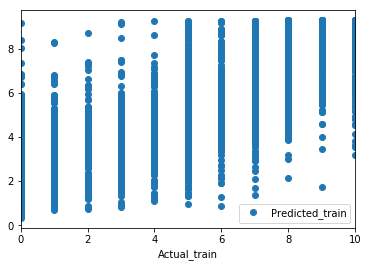

In [100]:
rest.plot(x="Actual_train",y="Predicted_train",style='o')
plt.show()

<h3> V. Applications </h3>

On va écrire une fonction qui permet de calculer la note prédite d'une phrase arbitraire inventée par nous mêmes.

In [101]:
def predit(verbatim):
    """ Takes as input a string and return a float value corresponding to the predicted grade (/10)"""
    if type(verbatim)!=str:
        return 10
    s,_,_=to_seq([verbatim])
    s=pad(s,maxlen)
    return best.predict(np.array(s)[:,:w,:])[0][0]  

In [120]:
""" Here the function is designed to predict a random sample of n observations from the testing set"""
import random
id_test=list(Base_test.index)
def sampp(n):
    res=[]
    val=[]
    tr=[]
    idx=random.sample(id_test, n)
    for i in idx:
        res.append(Base_test.raisons_recommandation[i])
        val.append(predit(Base_test.raisons_recommandation[i]))
        tr.append(Base_test.recommandation_SGK[i])
    df=pd.DataFrame()
    df["verbatim"]=res
    df["pred"]=val
    df["true"]=tr
    df["diff"]=abs(df["true"]-df["pred"])
    return df

"""We save the predictions for the entire test set"""
results=sampp(len(Base_test))
results.to_excel('Base_test_predicted.xlsx')

In [102]:
""" A few examples """
predit("j'ai adoré vos service")

9.244669

In [107]:
predit("j'ai mis trop longtemps à recevoir les informations que j'ai demandé, mais ce la reste convenable")

5.9930043

In [109]:
predit(" un service  nul")

2.4754243

<h3> VII. Error Analysis </h3>

A look at the misclassified sentences from the test set

En parcourant la base de test, on s'apperçoit que certaines verbatims ont des notes attribuées peu cohérentes avec leur contenu. Cela créé probablement du bruit et ne facilite pas l'entraînement.


Quelques exemples: 

In [137]:
predit("""Lenteur pour traiter les dossiers. Demande de factures d'honoraires et de ribs 
       au client et aussi au médecin même si le client a déjà donné les notes et un rib pour se faire rembourser. 
       La Sogecap semble ignorer que les médecins préfèrent soigner des malades que de remplir des papiers 
       (ces sont eux qui le disent !)""")

0.86576

In [145]:
Base_test.loc[3557] #la note attribuée par le client pour ce même avis est de 8/10

recommandation_SGK                                                        8
raisons_recommandation    Lenteur pour traiter les dossiers. Demande de ...
Name: 3557, dtype: object

In [146]:
predit("pas de reponse à ma requête")

1.9859983

In [147]:
Base_test.loc[3080] #la encore la note est de 8.

recommandation_SGK                                  8
raisons_recommandation    pas de reponse à ma requête
Name: 3080, dtype: object

In [148]:
predit("sans avis")

4.579034

In [149]:
Base_test.loc[4418] #la note attribuée est de 0.

recommandation_SGK                0
raisons_recommandation    Sans avis
Name: 4418, dtype: object

In [150]:
predit("Attente!!")

4.7394166

In [151]:
Base_test.loc[655] #note attribuée de 9

recommandation_SGK                9
raisons_recommandation    Attente!!
Name: 655, dtype: object

In [152]:
predit("J'ai tenté de joindre vos services pendant 2 jours avant de pouvoir avoir un conseiller !")

3.7019985

In [153]:
Base_test.loc[1973] #note attribuée 8

recommandation_SGK                                                        8
raisons_recommandation    J'ai tenté de joindre vos services pendant 2 j...
Name: 1973, dtype: object

Beaucoup d'autres exemples de notations assez étranges sont présents dans la base test (et la train), cela cause une erreur plus grande et aussi complique l'apprentissage à cause du bruit engendré.

<h3> VII. Weights Analysis</h3>